# Children's Assessment Perfomance Prediction

## Table of Contents

0. [Introduction](#Introduction)
1. [Import & Get Data](#Import-&-Get-Data)
3. [First insight into the Data](#First-insight-into-the-Data)
4. [A closer look on the Dataset](#A-closer-look-on-the-Dataset)
5. [Preprocess & Split the data into train/test sets](#Preprocess-&-Split-the-data-into-train/test-sets)
6. [Convert data to X/y form](#Convert-data-to-X/y-form)
7. [Feature Processing](#Feature-Processing)
8. [Feature Importance](#Feature-Importance)
9. [Training on the Preprocesed Features](#Training-on-the-Preprocesed-Features)
10. [The Quadratic Weighted Kappa Metric](#The-Quadratic-Weighted-Kappa-Metric)
11. [Random Grid search for the new scoring](#Random-Grid-search-for-the-new-scoring)
12. [Submitting to RAMP studio](#Submitting-to-RAMP-studio)

# Introduction

This challenge is about predicting the performance of children in brain games. That may sound a little useless, yet a lot of psychiatrists think it to be such treasure for the youth education. Indeed, correlations between having a good performance and some special data features like the frequency of playing some sort of videogames for an example may help understand the deep brain stimulations and what could be a major change in our way of teaching.

Through this challenge, you will have some anonymous data about the games that are played, types of those games, how the data is processed and the problems we may have with it. More descriptions will be given throughout this notebook when necessary.

# Import & Get Data

First, let's import the classical python Mandatory libraries. No guarantee our code is gonna match if you use your libs, however sometimes innovation brings beautiful surprises and the results do worth a try (and more).

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

Upset!! Yes, we know but the slower an information comes the longer it lasts ... This will be our way and get used to it ;) 

This challenge aims to predict if a child, given his past gaming history and a final game session assessment, will shine from his first attempt, make it through after a second chance, maybe after several trials or just sitting there without passing the assessment game at all.

Easy huh! :|


In [2]:
# Read data
data = pd.read_csv(r'data\train.csv.zip')

# First insight into the Data

The columns are as follows :

- `installation_id` : its an ID assigned to an installation instance, that means if you have a Snapchat installed on your device and you have never deleted it from it, you will always have the same installation ID. however, if you uninstall it and decide a beautiful that you missed your buddies on that app which means reinstall again, then you may find yourself with a new Installation ID. 

- `title` : it corresponds to the name of the game you are playing, you have 42 of them

- `type` : You have 4 types of games, but only one of them is useful for assessment, that's why maybe the data provider decided to name it accordingly.

- `world` : Every single game has an attribute about the Word where it, virtually, takes place.

- `game_session` and `game_time`: Remember we said that you have an Installation ID that may be the same for your whole life, well for this one rules change, at every time you start playing a game, you will have a game session ID. You can see it as your Facebook login history. We would then let you guess what Game Time stands for! 

- `event_code` and `timestamp`: When you launch a new game session you will go through several events dated by Timestamp column. For example, when starting a game has the code 2000 and that why you will see at each game session. Event code would correspond to commenting, liking or any other log activity on Instagram


In [3]:
data.head(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group
0,3bfd1a65,34abf0a24c2aaf91,2019-08-25 03:15:48.296000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00129856,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,NaN
1,db02c830,34abf0a24c2aaf91,2019-08-25 03:15:48.368000+00:00,"{""event_count"":2,""game_time"":41,""event_code"":2...",00129856,2,2025,41,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,NaN
2,a1e4395d,34abf0a24c2aaf91,2019-08-25 03:15:48.374000+00:00,"{""description"":""Pull three mushrooms out of th...",00129856,3,3010,41,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,NaN
3,f56e0afc,ae691ec5ad5652cf,2019-09-22 16:32:30.575000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00129856,1,2000,0,Bird Measurer (Assessment),Assessment,TREETOPCITY,3.0
4,27253bdc,07dce61ec6fd52ac,2019-09-05 13:52:48.101000+00:00,"{""event_code"": 2000, ""event_count"": 1}",001d0ed0,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682814 entries, 0 to 2682813
Data columns (total 12 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
accuracy_group     float64
dtypes: float64(1), int64(3), object(8)
memory usage: 245.6+ MB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
event_count,2682814.0,98.826822,128.110648,1.0,25.0,59.0,123.0,2505.0
event_code,2682814.0,3508.690562,680.664562,2000.0,3020.0,4020.0,4035.0,5010.0
game_time,2682814.0,172473.719303,981875.091671,0.0,30508.0,71126.0,149796.0,76653424.0
accuracy_group,2312.0,1.594291,1.262488,0.0,0.0,2.0,3.0,3.0


In [6]:
data[['installation_id','game_session','event_code','title','type','world']].nunique()

installation_id     2312
game_session       64202
event_code            42
title                 44
type                   4
world                  4
dtype: int64

# A closer look on the Dataset

In [7]:
data.groupby(['installation_id','game_session'])['title'].value_counts().head(20)

installation_id  game_session      title                       
00129856         34abf0a24c2aaf91  Mushroom Sorter (Assessment)      3
                 ae691ec5ad5652cf  Bird Measurer (Assessment)        1
001d0ed0         07dce61ec6fd52ac  Welcome to Lost Lagoon!           1
                 171c4da401da063c  Tree Top City - Level 2           1
                 b6dbceab4fdb7c80  Ordering Spheres                  1
                 c046a858e7c8bf03  Mushroom Sorter (Assessment)     64
                 c9051d01294907b3  Ordering Spheres                  1
                 d26232359fbda157  Tree Top City - Level 1           1
                 dc6bc0284039c9fb  Mushroom Sorter (Assessment)      1
                 f254185e012e45a8  Pirate's Tale                     1
00225f67         03828db3ffa51606  Flower Waterer (Activity)       122
                 0861b5e3302ab66e  Tree Top City - Level 3           1
                 1184d3e169326bc5  Bug Measurer (Activity)           3
             

We see that each user (**installation_id**) have multiple game sessions in which they play a particular activity (**title**). For each activity, a different number of events are performed.

We now do an analyse on the different titles in the given dataset.

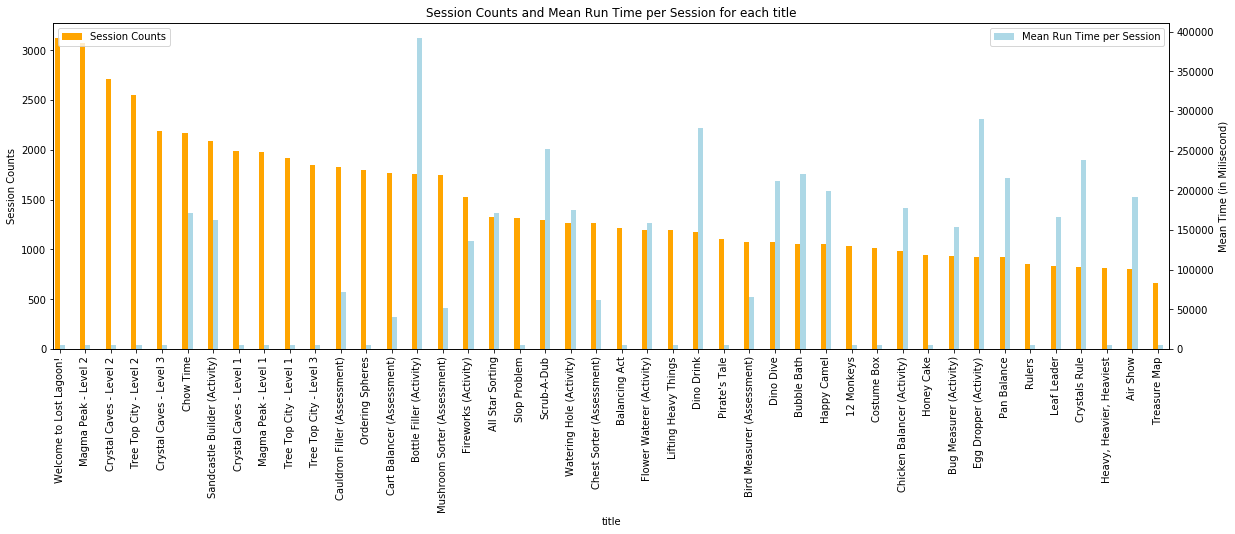

In [8]:
fig = plt.figure(figsize=(20,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

groupby_title = data.groupby(['game_session','title'])['game_time'].agg('max').groupby('title')\
            .agg(['count','mean']).sort_values(by='count',ascending=False)
# If we want to count events
# groupby_title = data.groupby(['game_session','title'])['event_count'].agg('sum').groupby('title')\
#             .agg(['count','mean']).sort_values(by='count',ascending=False)

groupby_title['count'].plot(kind='bar', color='orange', ax=ax, width=width, position=1, label='Session Counts')
# Add 5 seconds to avoid zeros in plot
(5000+groupby_title['mean']).plot(kind='bar', color='lightblue', ax=ax2, width=width, position=0, label='Mean Run Time per Session')

ax.set_ylabel('Session Counts')
ax2.set_ylabel('Mean Time (in Milisecond)')

ax.legend(loc='upper left')
ax2.legend()

plt.title('Session Counts and Mean Run Time per Session for each title')
plt.show()

We see that there are many activities that have high session counts but in constrast have zero run time. They are in fact the activities that require only one (or a few) event to complete. For example, the title **Welcome to Lost Lagoon!** corresponds to the opening scene of the application, hence it has the most number of times played. We also note that the mean run time of each session is not longer than $400 \ 000 \ ms$, or about $6$ minutes.

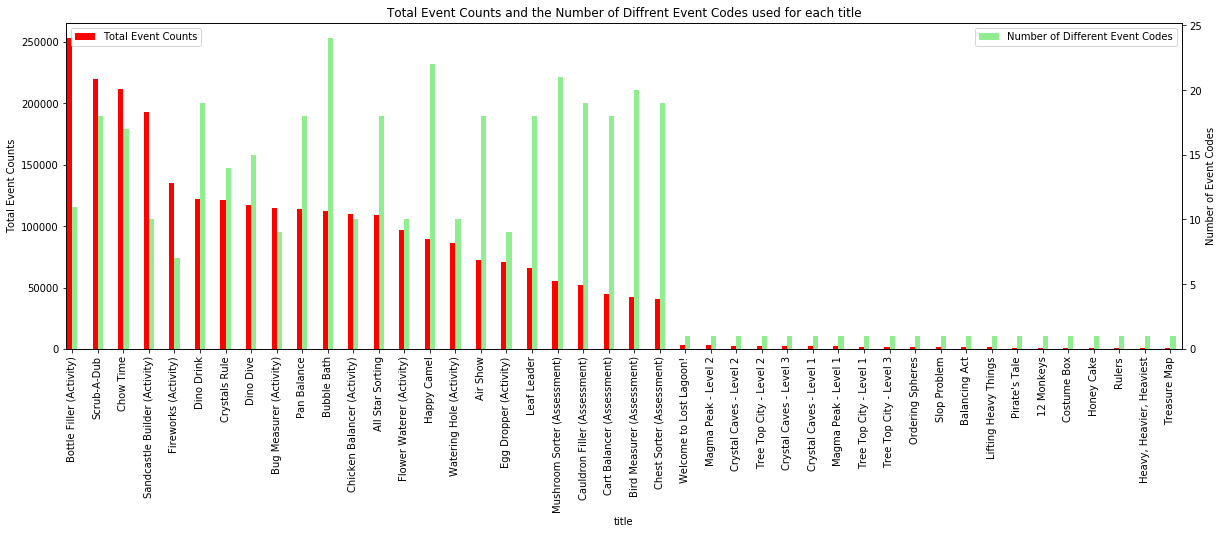

In [9]:
fig = plt.figure(figsize=(20,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

groupby_title = data.groupby('title')['event_code'].agg([pd.Series.nunique,'count'])\
            .sort_values(by='count',ascending=False)

groupby_title['count'].plot(kind='bar', color='red', ax=ax, width=width, position=1, label='Total Event Counts')
groupby_title['nunique'].plot(kind='bar', color='lightgreen', ax=ax2, width=width, position=0, label='Number of Different Event Codes')

ax.set_ylabel('Total Event Counts')
ax2.set_ylabel('Number of Event Codes')

ax.legend(loc='upper left')
ax2.legend()

plt.title('Total Event Counts and the Number of Diffrent Event Codes used for each title')
plt.show()

We see that half of the activities have very little events compared to other activities. If we look at the number of different event codes used for the activities, we see that these activities with low counts correspond to the activities with only one event code. We also notice that the activities with many event codes (meaning that it's more complex to play) tend to have low session counts or mean run time and hence lead to lower event counts.

Let's take a look at the different types of the activities.

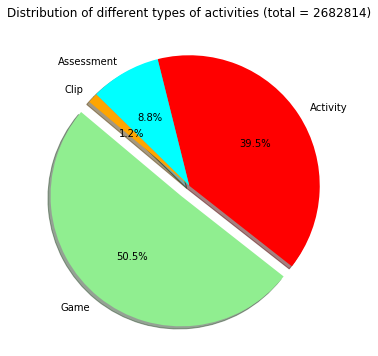

In [10]:
type_counts = data.type.value_counts()
# Data to plot
labels = type_counts.keys()
sizes = type_counts.values
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, 
        colors=['lightgreen', 'red','cyan','orange'],
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Distribution of different types of activities (total = %d)' %np.sum(sizes))
plt.show()

As we mentioned earlier, there are 4 types of action in the application: **Game**, **Activity**, **Assessment** and **Clip**. This plot tells us that most of the time the users play game or do activities with the application, while only a few percentage of users actually watch clip.

We then take a look at the different worlds.

C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


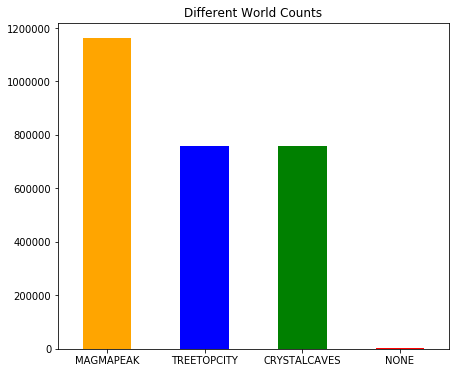

In [11]:
data.world.value_counts()\
        .plot.bar(figsize=(7,6), 
                  title='Different World Counts',
                  colors = ['orange','blue','green','red'], 
                  rot=0)

We see that most of the activities are taken on three worlds: **Magmapeak**, **Crystalcaves** and **Treetopcity**. 

We also note that each title is performed on a particular world.

In [12]:
print(data[['title','world']].drop_duplicates().head(10))
len(data[['title','world']].drop_duplicates()) == len(data[['title']].drop_duplicates())

                            title        world
0    Mushroom Sorter (Assessment)  TREETOPCITY
3      Bird Measurer (Assessment)  TREETOPCITY
4         Welcome to Lost Lagoon!         NONE
5         Tree Top City - Level 1  TREETOPCITY
6                Ordering Spheres  TREETOPCITY
8         Tree Top City - Level 2  TREETOPCITY
9                   Pirate's Tale  TREETOPCITY
78               All Star Sorting  TREETOPCITY
200                   Costume Box  TREETOPCITY
201          Fireworks (Activity)  TREETOPCITY


True

In [13]:
world_dict = data.groupby(['world'])['title'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
for world in world_dict:
    print("==============Titles on World " + world + "=================")
    print(", ".join(sorted(world_dict[world])))
    print()

==============Titles on World CRYSTALCAVES=================
Balancing Act, Cart Balancer (Assessment), Chest Sorter (Assessment), Chicken Balancer (Activity), Chow Time, Crystal Caves - Level 1, Crystal Caves - Level 2, Crystal Caves - Level 3, Egg Dropper (Activity), Happy Camel, Heavy, Heavier, Heaviest, Honey Cake, Leaf Leader, Lifting Heavy Things, Pan Balance

==============Titles on World MAGMAPEAK=================
Bottle Filler (Activity), Bubble Bath, Cauldron Filler (Assessment), Dino Dive, Dino Drink, Magma Peak - Level 1, Magma Peak - Level 2, Sandcastle Builder (Activity), Scrub-A-Dub, Slop Problem, Watering Hole (Activity)

==============Titles on World NONE=================
Welcome to Lost Lagoon!

==============Titles on World TREETOPCITY=================
12 Monkeys, Air Show, All Star Sorting, Bird Measurer (Assessment), Bug Measurer (Activity), Costume Box, Crystals Rule, Fireworks (Activity), Flower Waterer (Activity), Mushroom Sorter (Assessment), Ordering Spheres, P

We finally pay attention to the timestamps in the data.

In [14]:
df_times = data.loc[:,['timestamp']]
df_times['timestamp'] = pd.to_datetime(df_times['timestamp'])
df_times['date'] = df_times['timestamp'].dt.date

In [15]:
print("Number of dates in the dataset:",df_times['date'].nunique())
print("First date:",min(df_times['date']))
print("Last date:",max(df_times['date']))

Number of dates in the dataset: 84
First date: 2019-07-23
Last date: 2019-10-14


We see that the data is collected on 84 days from **23/07/2019** to **14/10/2019**.

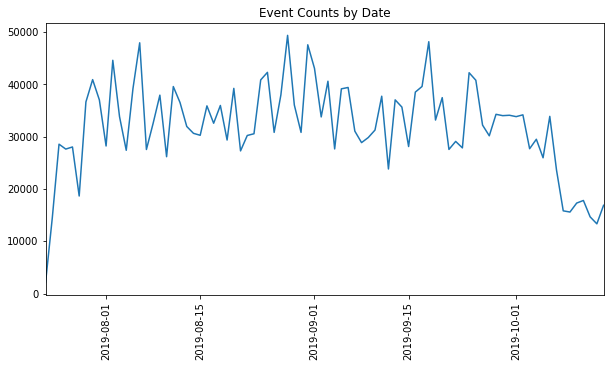

In [16]:
df_times['date'].value_counts().sort_index().plot(figsize=(10,5), rot=90, title = "Event Counts by Date")

We see that the number of events played increases gradually until the first of October.

Now we are going to plot the number of observations by the days of the week and the time of the days.

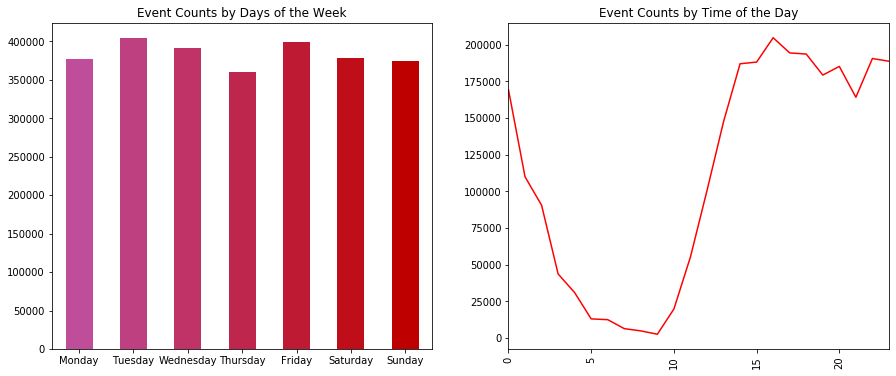

In [17]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_times['timestamp'].dt.weekday_name.value_counts()\
    [['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]\
            .plot.bar(
                  title='Event Counts by Days of the Week',
                  color = [(0.75, x/20.0, x/10.0) for x in reversed(range(7))], 
                  rot=0, ax= ax1)

df_times['timestamp'].dt.hour.value_counts().sort_index()\
        .plot(rot=90, title = "Event Counts by Time of the Day", color = 'red')

# Preprocess & Split the data into train/test sets

To have a consistent model we need to split into two folders, one for training and a second for testing! You know why of course, overfitting, Boy!

As we only care about the Assessment type (with **event_code**=4100, or 4110 for **Bird Measurer**), we only take the events with these information. To avoid overfitting, we also take out of all the installation_id that appear in the train set from the test set so that users appearing in train set are not present in test set.

In [18]:
def get_train_test(df, test_frac=0.25):
    """
    Splits the dataset into train and test sets according to the challenge procedure
    """

    ids_attempted = df[(df.type == 'Assessment') & \
                       ((df.event_code == 4100) & (df.title != 'Bird Measurer (Assessment)') |
                       (df.event_code == 4110) & (df.title == 'Bird Measurer (Assessment)'))] \
                       .installation_id.unique()
    test_ids = np.random.choice(ids_attempted, size=int(test_frac * len(ids_attempted)), replace=False)

    train = df[~df.installation_id.isin(test_ids)].reset_index(drop=True)
    test = df[df.installation_id.isin(test_ids)].reset_index(drop=True)

    return train, test

In [19]:
# Split train/test
train, test = get_train_test(data)

# Convert data to X/y form


Let us have a quick flashback for a little while if we assume that every installation id corresponds exactly to a single child then our task is to guess whether or not he going to succeed in the last assessment game he had from one try, two extra ... We have four classes to put a child in (group 0: never make it through (the smarted of course), group 1: they are persevering and beat the game after at least 3 trials, group 2: the dumbest they prefer to fail at first attempt and succeed at a second just to lower their score, finally group 3: Hell, if I only had 1% of their luck, those guys smash everything at the first time). That's how we generate our target Y from both folders train and test. 

For some iid matters, we will truncate the history of every installation id at a random Assessment game, chosen uniformly among all assessment game sessions for that installation id, and whose details are be hidden for prediction purposes.

In [20]:
def truncate_and_get_y(df):
    """
    Truncates the dataset randomly for each user, according to the challenge procedure
    Also returns y before the information is lost through the truncation
    """

    # Sort dataframe
    df = df.copy()
    df.timestamp = pd.to_datetime(df.timestamp)
    df.sort_values(['installation_id', 'timestamp'], inplace=True)

    # Filter dataframe
    df_attempts = df[(df.type == 'Assessment') & \
                    ((df.event_code == 4100) & (df.title != 'Bird Measurer (Assessment)') |
                     (df.event_code == 4110) & (df.title == 'Bird Measurer (Assessment)'))].copy()
    df = df[df.installation_id.isin(df_attempts.installation_id.unique())].copy().reset_index(drop=True)

    # Compute y
    df_attempts['success'] = df_attempts.event_data.apply(lambda x: json.loads(x)['correct']) * 1
    passed = df_attempts.groupby('game_session').success.max().to_frame('passed')
    n_attempts = df_attempts.groupby('game_session').size().to_frame('n_attempts')
    accuracy = pd.Series(0, index=passed.index)
    accuracy.loc[(passed.passed == 1) & (n_attempts.n_attempts > 2)] = 1
    accuracy.loc[(passed.passed == 1) & (n_attempts.n_attempts == 2)] = 2
    accuracy.loc[(passed.passed == 1) & (n_attempts.n_attempts == 1)] = 3

    selected_sessions = df_attempts.groupby('installation_id').game_session\
        .apply(lambda obj: obj.loc[np.random.choice(obj.index)])
    y = pd.Series(accuracy.loc[selected_sessions].values, index=selected_sessions.index)

    # Truncate
    df['idx'] = df.index
    marked_start = df.game_session.isin(selected_sessions) \
        & df.idx.isin(df.groupby('game_session').idx.first())
    marked_start = marked_start[marked_start].index
    marked_end = df.idx.isin(df.groupby('installation_id').idx.last())
    marked_end = marked_end[marked_end].index
    df.drop('idx', axis=1, inplace=True)
    idx = list(range(marked_start[0] + 1))
    for start, end in zip(marked_start[1:], marked_end[:-1]):
        idx += list(range(end + 1, start + 1))
    df = df.loc[idx]

    return df, y

In [21]:
# Truncate and get y
train, y_train = truncate_and_get_y(train)
test, y_test = truncate_and_get_y(test)

In [22]:
len(train.installation_id.unique())

961

In [23]:
len(y_train)

961

Now let's take a look at the labels. As we can see below the labels are not well distributed.

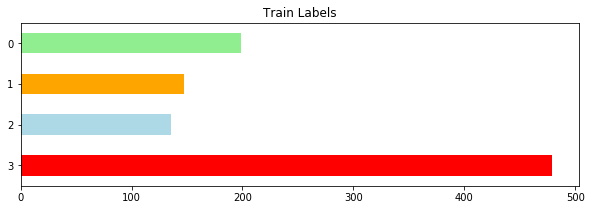

In [24]:
y_train.value_counts().sort_index(ascending=False) \
    .plot(kind='barh', figsize=(10, 3), title='Train Labels', color=['r','lightblue','orange','lightgreen'])
plt.show()

# Feature Processing

Preprocessing features : 

- `n_sessions` : number of sessions for each user

- `unique_events_per_session` : mean number of unique events in a session for each user

- `mean_game_time` : mean game time in a session for each user

- `min_hour` : earliest hour played for each user

- `mean_hour` : mean hour played for each user

- `max_hour` : latest hour played for each user

- `most_played_dayofweek` : most played day of the week for each user

- `first_day` : the day the user first played, for each user

- `median_day` : the median day the user has played, for each user

- `hour` : the hour at the time the assessment we want to predict has occurred

- `dayofweek` : the day of the week at the time the assessment we want to predict has occurred

- `day` : the day at the time the assessment we want to predict has occurred

- `total_days` : the number of different days the user has played before the assessment we want to predict occurred

- `prediction_assessment_{title}`: whether the assessment we have to predict is this title or not, for each user

- `prediction_world_{title}`: whether the assessment we have to predict belongs to that world or not, for each user

- `type_{type}`: the number of times the user has played a title belonging to that type can be 'Assessment', 'Game', 'Clip' or 'Activity'

- `world_{world}` : the number of times the user has played a title belonging to that world can be 'MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES' or 'NONE'

- `n_events_per_session_{event_code}` : the mean number of times a given event_code has occurred per game session, for that user

- `mean_passed`: percentage of the assessments passed among the attempted assessments for each user

- `mean_attempts`: mean number of attempts among the attempted assessments for each user

- `max_attempts`: maximum number of attempts among the attempted assessments for each user

- `n_sessions_{title}` : number of sessions of a given title, for each user

- `unique_events_{title}`: mean number of unique events happening in a session of a given title, for each user

- `game_time_{title}`: mean game time in a session of a given title, for each user

- `mean_passed_{title}`: percentage of the assessments passed among the attempted assessments for a given title, for each user

- `mean_attempts_{title}`: mean number of attempts among the attempted assessments for a given title, for each user

- `max_attempts_{title}`: maximum number of attempts among the attempted assessments for a given title, for each user


**PS**: These are the features we thought to be relevant toward the prediction task, some of them that finally were not, are dropped off at the end. Those are typically columns with only one value because they do not give any additional information. However, feel free to add whatever could sound plausible as a key feature.

In [25]:
def preprocessing(df, train_cols=None):

    # Clean dataset
    df = df.copy()
    df['hour'] = df.timestamp.dt.hour
    df['dayofweek'] = df.timestamp.dt.dayofweek
    df['dayofyear'] = df.timestamp.dt.dayofyear
    df_attempts = df[(df.type == 'Assessment') & \
                    ((df.event_code == 4100) & (df.title != 'Bird Measurer (Assessment)') |
                     (df.event_code == 4110) & (df.title == 'Bird Measurer (Assessment)'))].copy()
    df_attempts['success'] = df_attempts.event_data.apply(lambda x: json.loads(x)['correct']) * 1
    passed = df_attempts.groupby(['installation_id', 'game_session']).success.max()\
        .to_frame('passed').reset_index()
    n_attempts = df_attempts.groupby(['installation_id', 'game_session']).size()\
        .to_frame('n_attempts').reset_index()

    # Build features
    # General user features
    X = pd.DataFrame()
    X['n_sessions'] = df.groupby('installation_id').game_session.nunique()
    X['unique_events_per_session'] = df.groupby('installation_id').size()
    X.unique_events_per_session /= X.n_sessions
    game_time = df.groupby(['installation_id', 'game_session']).game_time.max().reset_index()
    X['mean_game_time'] = game_time.groupby('installation_id').game_time.mean()

    # Time user features
    hour = df.groupby(['installation_id', 'game_session']).hour.first().reset_index()
    X['min_hour'] = hour.groupby('installation_id').hour.min()
    X['mean_hour'] = hour.groupby('installation_id').hour.mean()
    X['max_hour'] = hour.groupby('installation_id').hour.max()
    dayofweek_count = df.groupby(['installation_id', 'dayofweek'])\
        .game_session.nunique().to_frame('count').reset_index()
    dayofweek_count.sort_values(['installation_id', 'count'], inplace=True)
    X['most_played_dayofweek'] = dayofweek_count.groupby('installation_id').dayofweek.last()
    X['first_day'] = df.groupby('installation_id').dayofyear.min()
    different_days = df.groupby(['installation_id', 'dayofyear']).size().reset_index()
    X['median_day'] = different_days.groupby('installation_id').dayofyear.median()

    X['hour'] = df.groupby('installation_id').hour.last()
    X['dayofweek'] = df.groupby('installation_id').dayofweek.last()
    X['day'] = df.groupby('installation_id').dayofyear.last()
    X['total_days'] = df.groupby('installation_id').dayofyear.nunique()

    # Predicted game features
    prediction_assessment = df.groupby('installation_id').title.last()\
        .to_frame('last').reset_index()
    prediction_assessment['occurred'] = 1
    prediction_assessment = prediction_assessment\
        .pivot(index='installation_id', columns='last', values='occurred').fillna(0)
    prediction_assessment.columns = ['prediction_assessment_{}'.format(c)
                                     for c in prediction_assessment.columns]
    X = X.merge(prediction_assessment, how='left', left_index=True, right_index=True)

    prediction_world = df.groupby('installation_id').world.last()\
        .to_frame('last').reset_index()
    prediction_world['occurred'] = 1
    prediction_world = prediction_world\
        .pivot(index='installation_id', columns='last', values='occurred').fillna(0)
    prediction_world.columns = ['prediction_world_{}'.format(c)
                                     for c in prediction_world.columns]
    X = X.merge(prediction_world, how='left', left_index=True, right_index=True)

    # Gameplay user features
    type_counts = df.groupby(['installation_id', 'type']).game_session.nunique()\
        .reset_index().pivot(index='installation_id', columns='type', values='game_session').fillna(0)
    type_counts.columns = ['type_{}'.format(c) for c in type_counts.columns]
    X = X.merge(type_counts, how='left', left_index=True, right_index=True)

    world_counts = df.groupby(['installation_id', 'world']).game_session.nunique()\
        .reset_index().pivot(index='installation_id', columns='world', values='game_session').fillna(0)
    world_counts.columns = ['world_{}'.format(c) for c in world_counts.columns]
    X = X.merge(world_counts, how='left', left_index=True, right_index=True)

    event_counts = df.groupby(['installation_id', 'event_code']).event_count.sum()\
        .reset_index().pivot(index='installation_id', columns='event_code', values='event_count').fillna(0)
    event_counts = event_counts.div(X.n_sessions, axis=0)
    event_counts.columns = ['n_events_per_session_{}'.format(c) for c in event_counts.columns]
    X = X.merge(event_counts, how='left', left_index=True, right_index=True)

    # Success user features
    X['mean_passed'] = passed.groupby('installation_id').passed.mean()
    X.mean_passed.fillna(-1, inplace=True)
    X['mean_attempts'] = n_attempts.groupby('installation_id').n_attempts.mean()
    X['max_attempts'] = n_attempts.groupby('installation_id').n_attempts.max()
    X.fillna(0, inplace=True)

    # General user features for each title
    title_sessions = df.groupby(['installation_id', 'title']).game_session.nunique()\
        .reset_index().pivot(index='installation_id', columns='title', values='game_session').fillna(0)
    title_unique_events = df.groupby(['installation_id', 'title']).size().to_frame('size')\
        .reset_index().pivot(index='installation_id', columns='title', values='size')
    title_unique_events  = (title_unique_events / title_sessions).fillna(0)
    title_sessions.columns = ['n_sessions_{}'.format(c) for c in title_sessions.columns]
    title_unique_events.columns = ['unique_events_{}'.format(c) for c in title_unique_events.columns]
    X = X.merge(title_sessions, how='left', left_index=True, right_index=True)
    X = X.merge(title_unique_events, how='left', left_index=True, right_index=True)

    game_time = df.groupby(['installation_id', 'title', 'game_session']).game_time.max().reset_index()
    title_times = game_time.groupby(['installation_id', 'title']).game_time.mean()\
        .reset_index().pivot(index='installation_id', columns='title', values='game_time').fillna(0)
    title_times.columns = ['game_time_{}'.format(c) for c in title_times.columns]
    X = X.merge(title_times, how='left', left_index=True, right_index=True)

    # Success user features for each assessment
    passed = df_attempts.groupby(['installation_id', 'title', 'game_session']).success.max()\
        .to_frame('passed').reset_index()
    n_attempts = df_attempts.groupby(['installation_id', 'title', 'game_session']).size()\
        .to_frame('n_attempts').reset_index()
    title_passed = passed.groupby(['installation_id', 'title']).passed.mean().to_frame('mean')\
        .reset_index().pivot(index='installation_id', columns='title', values='mean')
    title_passed.columns = ['mean_passed_{}'.format(c) for c in title_passed.columns]
    X = X.merge(title_passed, how='left', left_index=True, right_index=True).fillna(-1)

    title_mean_attempts = n_attempts.groupby(['installation_id', 'title'])\
        .n_attempts.mean().to_frame('mean')\
        .reset_index().pivot(index='installation_id', columns='title', values='mean')
    title_mean_attempts.columns = ['mean_attempts_{}'.format(c) for c in title_mean_attempts.columns]
    X = X.merge(title_mean_attempts, how='left', left_index=True, right_index=True).fillna(0)

    title_max_attempts = n_attempts.groupby(['installation_id', 'title'])\
        .n_attempts.max().to_frame('max')\
        .reset_index().pivot(index='installation_id', columns='title', values='max')
    title_max_attempts.columns = ['max_attempts_{}'.format(c) for c in title_max_attempts.columns]
    X = X.merge(title_max_attempts, how='left', left_index=True, right_index=True).fillna(0)
    # X['installation_id'] = df.installation_id.unique()

    # Drop columns with only 1 modality
    if train_cols is None:
        X = X.loc[:, X.nunique() != 1]
    else:
        X = X.loc[:, train_cols]

    return X

All the features above as one can notice are numerical variables except for the days' related columns as well as hours related columns. The problem that day hours are cyclic and so defining a mean could not be that easy. That means that 11 pm would be closer to 8 pm than it is for 1 am. The problem is the same for the days of the week. Here are solutions to avoid all biases caused by this :

- We may project the variables on a cercle 

<img src="hours.png">

- In case that you use a regressor, you may proceed using Bayesian estimators, in machine learning jargon using target encoding : $ Encoding(X) \,  = \,  E(Y| X = \, day \, or \, hour )$



In [26]:
# Extract features
X_train = preprocessing(train)
X_test = preprocessing(test, train_cols=X_train.columns)

In [27]:
X_train.shape

(961, 200)

In [28]:
X_train.head()

,n_sessions,unique_events_per_session,mean_game_time,min_hour,mean_hour,max_hour,most_played_dayofweek,first_day,median_day,hour,...,mean_attempts_Bird Measurer (Assessment),mean_attempts_Cart Balancer (Assessment),mean_attempts_Cauldron Filler (Assessment),mean_attempts_Chest Sorter (Assessment),mean_attempts_Mushroom Sorter (Assessment),max_attempts_Bird Measurer (Assessment),max_attempts_Cart Balancer (Assessment),max_attempts_Cauldron Filler (Assessment),max_attempts_Chest Sorter (Assessment),max_attempts_Mushroom Sorter (Assessment)
installation_id,,,,,,,,,,,,,,,,,,,,,
001d0ed0,7,1.000000,0.000000,13,13.000000,13,3,248,248.0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003372b0,35,28.971429,33667.314286,13,13.000000,13,3,269,269.0,13,...,2.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0
00634433,7,15.000000,21807.571429,20,20.000000,20,2,282,282.0,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01bdd720,42,52.619048,65626.333333,0,4.642857,16,6,258,258.0,16,...,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,4.0,0.0
01cc53f3,9,22.888889,21438.777778,18,18.000000,18,1,227,236.5,18,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Let's take a brief look at some features!

C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Haiyen Vu\Anaconda3\lib\site-pac

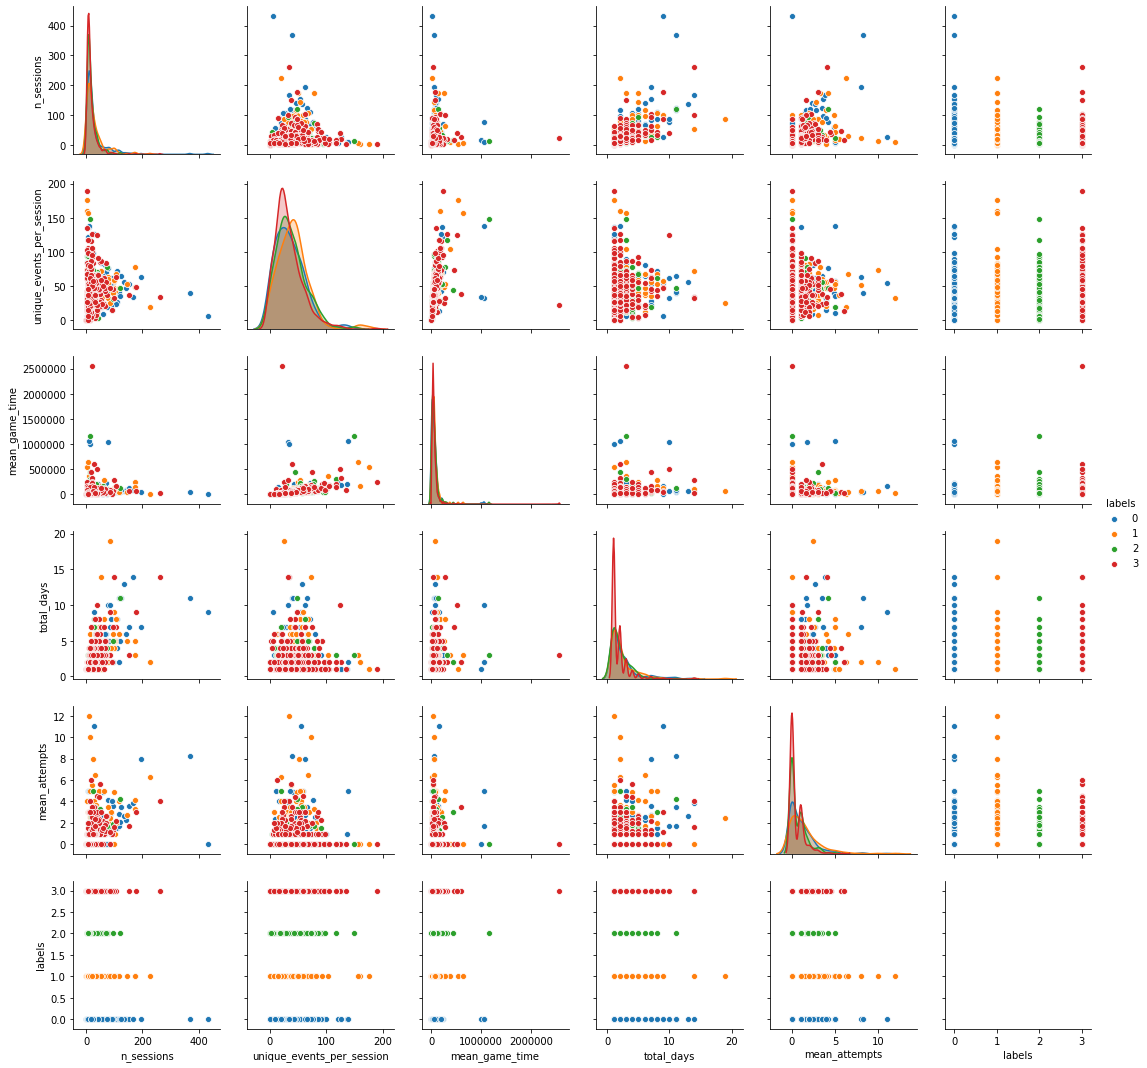

In [29]:
X_train_toplot = X_train[['n_sessions','unique_events_per_session','mean_game_time','total_days','mean_attempts']]
X_train_toplot.loc[:,'labels'] = y_train
sns.pairplot(X_train_toplot, hue="labels")

Looking at the distribution of the labels, we can infer that:
* Interestingly, children that spent a lot of time (*n_sessions, mean_game_time, total_days*) playing tend to fail on assessment (with label **0**), or succeed on the first attempt.
* Children that can deal with using many events (*unique_events_per_session*) tend to succeed on the first attempt.
* As long as the children have higher attempts in average (*mean_attempts*), they tend to answer less correctly.

Now if we take a look at some pair plots, we can observe some behaviors:
* *total_days* vs *n_sessions*: The longer the children play, the more sessions they have.
* *unique_events_per_session* vs *total_days*: The more complex the games are, the less days the children play on.
* *unique_events_per_session* vs *mean_attempts*: The more smart the children are, the less attempts they make.

# Feature Importance

Now we gonna use a Random Forest Classifier to find some features that are the most important.

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

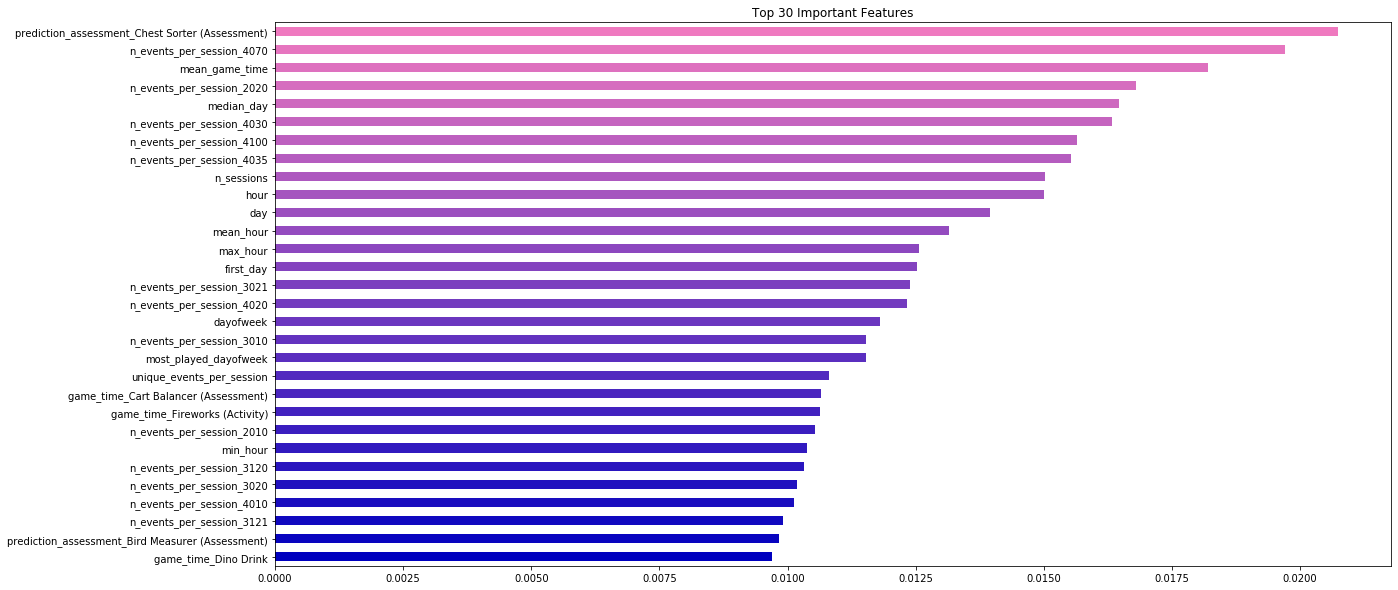

In [32]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
n_take =30
feat_importances.nlargest(n_take).sort_values(ascending=True)\
        .plot(figsize=(20,10),
              kind='barh',
              color = [(x/(n_take+1), x/(2*n_take+1), 0.75) for x in range(n_take)],
                 title = 'Top %d Important Features' %n_take)

We see that the number of occurences of some events are important to predict the performance of the children.

Perform direct prediction using a random search or a grid search with cross validation

# Training on the Preprocesed Features

In [33]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [34]:
estimator = RFC(max_depth=3, max_features=150, n_estimators= 15)

In [35]:
estimator.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=150, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
predicted_y = estimator.predict(X_test)

In [37]:
score = np.mean(predicted_y == y_test)

In [38]:
score

0.5875

We are still too far from having a reliable model and have to dive deep into the model construction. 

This is could be a plausible lead: Lying and lying too much?

# The Quadratic Weighted Kappa Metric

Till now we have been somehow considering that telling that someone that a child, who succeeded from its first attempt, had succeeded from its second attempt is the same as telling that he made it from three and more attempts. 

The metric used in scoring is symmetrical while the problem decision maybe not be symmetrical.

That means we need to change our scoring ! We'll use a metric called **Quadratic Weighted Kappa**, which allows to weight the disagreement between two outcomes. This metric is especially useful when the different classes are ordered.

Formally, let us denote $N$ by number of different classes. The calculation of the quadratic weighted kappa involves three matrices:
* An $N \times N$ weight matrix $W$ which penalizes the disagreements between classes, with:
$$w_{i,j} = \frac{\left(i-j\right)^2}{\left(N-1\right)^2}.$$
* An $N \times N$ histogram matrix $O$ such that $O_{i,j}$ corresponds to the number of instances in class $i$ (actual) that are predicted as $j$.
* An $N \times N$ histogram matrix of expected outcomes, $E$, is calculated assuming that there is no correlation between values.  This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that $E$ and $O$ have the same sum.
Finally, the quadratic weighted kappa is calculated as:
$$\kappa=1-\frac{\sum_{i,j}w_{i,j}O_{i,j}}{\sum_{i,j}w_{i,j}E_{i,j}}.$$

-For more information, please check out at the following links : 

https://scikitlearn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html

https://en.wikipedia.org/wiki/Cohen%27s_kappa


**From now on we will be using the quadratic weighted kappa metic for models assessment and it's going to be the one used to assess your submitted model**

In [39]:
from sklearn.metrics import cohen_kappa_score as scoring_kappa

from sklearn.metrics import make_scorer

def score(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    
    score = scoring_kappa(y_true,y_pred,weights='quadratic')
    
    return score

scoring = make_scorer(score, greater_is_better=True)

# Random Grid search for the new scoring

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC


#randomize hyperparameters selection to get better more effective results

max_depth_range = np.random.permutation(np.arange(1,50))[:5]
max_features_range = np.random.permutation(np.arange(1,200))[:5]
#max_features_range = np.array([163])
n_estimators_range = np.random.permutation(np.arange(1,20))[:5]

#the hyperparameters grid
param_grid = {'n_estimators' : n_estimators_range, 'max_depth': max_depth_range, 'max_features': max_features_range}


#hyperparameters selection with respect to the cross validation criterion using the new metric
grid = GridSearchCV(RFC(), param_grid=param_grid, verbose=3, scoring = scoring,  return_train_score=True)

In [41]:
grid.fit(X_train,y_train)

C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 125 candidates, totalling 375 fits
[CV] max_depth=48, max_features=85, n_estimators=1 ...................
[CV]  max_depth=48, max_features=85, n_estimators=1, score=(train=0.714, test=0.192), total=   0.0s
[CV] max_depth=48, max_features=85, n_estimators=1 ...................
[CV]  max_depth=48, max_features=85, n_estimators=1, score=(train=0.760, test=0.288), total=   0.0s
[CV] max_depth=48, max_features=85, n_estimators=1 ...................
[CV]  max_depth=48, max_features=85, n_estimators=1, score=(train=0.723, test=0.286), total=   0.0s
[CV] max_depth=48, max_features=85, n_estimators=18 ..................
[CV]  max_depth=48, max_features=85, n_estimators=18, score=(train=0.993, test=0.390), total=   0.2s
[CV] max_depth=48, max_features=85, n_estimators=18 ..................
[CV]  max_depth=48, max_features=85, n_estimators=18, score=(train=0.997, test=0.290), total=   0.2s
[CV] max_depth=48, max_features=85, n_estimators=18 ..................
[CV]  max

[CV]  max_depth=48, max_features=140, n_estimators=18, score=(train=0.995, test=0.395), total=   0.3s
[CV] max_depth=48, max_features=140, n_estimators=18 .................
[CV]  max_depth=48, max_features=140, n_estimators=18, score=(train=0.990, test=0.376), total=   0.3s
[CV] max_depth=48, max_features=140, n_estimators=18 .................
[CV]  max_depth=48, max_features=140, n_estimators=18, score=(train=0.992, test=0.375), total=   0.3s
[CV] max_depth=48, max_features=140, n_estimators=13 .................
[CV]  max_depth=48, max_features=140, n_estimators=13, score=(train=0.981, test=0.374), total=   0.2s
[CV] max_depth=48, max_features=140, n_estimators=13 .................
[CV]  max_depth=48, max_features=140, n_estimators=13, score=(train=0.989, test=0.358), total=   0.2s
[CV] max_depth=48, max_features=140, n_estimators=13 .................
[CV]  max_depth=48, max_features=140, n_estimators=13, score=(train=0.988, test=0.389), total=   0.2s
[CV] max_depth=48, max_features=1

[CV]  max_depth=25, max_features=18, n_estimators=6, score=(train=0.946, test=0.252), total=   0.0s
[CV] max_depth=25, max_features=18, n_estimators=6 ...................
[CV]  max_depth=25, max_features=18, n_estimators=6, score=(train=0.949, test=0.256), total=   0.0s
[CV] max_depth=25, max_features=18, n_estimators=6 ...................
[CV]  max_depth=25, max_features=18, n_estimators=6, score=(train=0.968, test=0.142), total=   0.0s
[CV] max_depth=25, max_features=184, n_estimators=1 ..................
[CV]  max_depth=25, max_features=184, n_estimators=1, score=(train=0.706, test=0.250), total=   0.0s
[CV] max_depth=25, max_features=184, n_estimators=1 ..................
[CV]  max_depth=25, max_features=184, n_estimators=1, score=(train=0.720, test=0.291), total=   0.0s
[CV] max_depth=25, max_features=184, n_estimators=1 ..................
[CV]  max_depth=25, max_features=184, n_estimators=1, score=(train=0.735, test=0.198), total=   0.0s
[CV] max_depth=25, max_features=184, n_est

[CV]  max_depth=42, max_features=85, n_estimators=1, score=(train=0.759, test=0.292), total=   0.0s
[CV] max_depth=42, max_features=85, n_estimators=1 ...................
[CV]  max_depth=42, max_features=85, n_estimators=1, score=(train=0.675, test=0.229), total=   0.0s
[CV] max_depth=42, max_features=85, n_estimators=1 ...................
[CV]  max_depth=42, max_features=85, n_estimators=1, score=(train=0.706, test=0.194), total=   0.0s
[CV] max_depth=42, max_features=85, n_estimators=18 ..................
[CV]  max_depth=42, max_features=85, n_estimators=18, score=(train=0.999, test=0.371), total=   0.2s
[CV] max_depth=42, max_features=85, n_estimators=18 ..................
[CV]  max_depth=42, max_features=85, n_estimators=18, score=(train=0.997, test=0.310), total=   0.2s
[CV] max_depth=42, max_features=85, n_estimators=18 ..................
[CV]  max_depth=42, max_features=85, n_estimators=18, score=(train=0.993, test=0.382), total=   0.2s
[CV] max_depth=42, max_features=85, n_esti

[CV]  max_depth=42, max_features=140, n_estimators=18, score=(train=0.993, test=0.435), total=   0.3s
[CV] max_depth=42, max_features=140, n_estimators=18 .................
[CV]  max_depth=42, max_features=140, n_estimators=18, score=(train=0.993, test=0.224), total=   0.3s
[CV] max_depth=42, max_features=140, n_estimators=18 .................
[CV]  max_depth=42, max_features=140, n_estimators=18, score=(train=0.995, test=0.374), total=   0.3s
[CV] max_depth=42, max_features=140, n_estimators=13 .................
[CV]  max_depth=42, max_features=140, n_estimators=13, score=(train=0.987, test=0.403), total=   0.2s
[CV] max_depth=42, max_features=140, n_estimators=13 .................
[CV]  max_depth=42, max_features=140, n_estimators=13, score=(train=0.976, test=0.353), total=   0.2s
[CV] max_depth=42, max_features=140, n_estimators=13 .................
[CV]  max_depth=42, max_features=140, n_estimators=13, score=(train=0.980, test=0.325), total=   0.2s
[CV] max_depth=42, max_features=1

[CV]  max_depth=37, max_features=18, n_estimators=13, score=(train=0.988, test=0.363), total=   0.0s
[CV] max_depth=37, max_features=18, n_estimators=13 ..................
[CV]  max_depth=37, max_features=18, n_estimators=13, score=(train=0.982, test=0.265), total=   0.0s
[CV] max_depth=37, max_features=18, n_estimators=13 ..................
[CV]  max_depth=37, max_features=18, n_estimators=13, score=(train=0.980, test=0.312), total=   0.0s
[CV] max_depth=37, max_features=18, n_estimators=4 ...................
[CV]  max_depth=37, max_features=18, n_estimators=4, score=(train=0.888, test=0.325), total=   0.0s
[CV] max_depth=37, max_features=18, n_estimators=4 ...................
[CV]  max_depth=37, max_features=18, n_estimators=4, score=(train=0.860, test=0.307), total=   0.0s
[CV] max_depth=37, max_features=18, n_estimators=4 ...................
[CV]  max_depth=37, max_features=18, n_estimators=4, score=(train=0.884, test=0.337), total=   0.0s
[CV] max_depth=37, max_features=18, n_esti

[CV]  max_depth=37, max_features=137, n_estimators=4, score=(train=0.882, test=0.346), total=   0.1s
[CV] max_depth=37, max_features=137, n_estimators=4 ..................
[CV]  max_depth=37, max_features=137, n_estimators=4, score=(train=0.875, test=0.295), total=   0.1s
[CV] max_depth=37, max_features=137, n_estimators=4 ..................
[CV]  max_depth=37, max_features=137, n_estimators=4, score=(train=0.875, test=0.240), total=   0.1s
[CV] max_depth=37, max_features=137, n_estimators=6 ..................
[CV]  max_depth=37, max_features=137, n_estimators=6, score=(train=0.924, test=0.371), total=   0.1s
[CV] max_depth=37, max_features=137, n_estimators=6 ..................
[CV]  max_depth=37, max_features=137, n_estimators=6, score=(train=0.974, test=0.300), total=   0.1s
[CV] max_depth=37, max_features=137, n_estimators=6 ..................
[CV]  max_depth=37, max_features=137, n_estimators=6, score=(train=0.924, test=0.303), total=   0.1s
[CV] max_depth=27, max_features=85, n_e

[CV]  max_depth=27, max_features=184, n_estimators=6, score=(train=0.944, test=0.254), total=   0.1s
[CV] max_depth=27, max_features=184, n_estimators=6 ..................
[CV]  max_depth=27, max_features=184, n_estimators=6, score=(train=0.941, test=0.389), total=   0.1s
[CV] max_depth=27, max_features=140, n_estimators=1 ..................
[CV]  max_depth=27, max_features=140, n_estimators=1, score=(train=0.743, test=0.265), total=   0.0s
[CV] max_depth=27, max_features=140, n_estimators=1 ..................
[CV]  max_depth=27, max_features=140, n_estimators=1, score=(train=0.777, test=0.165), total=   0.0s
[CV] max_depth=27, max_features=140, n_estimators=1 ..................
[CV]  max_depth=27, max_features=140, n_estimators=1, score=(train=0.741, test=0.211), total=   0.0s
[CV] max_depth=27, max_features=140, n_estimators=18 .................
[CV]  max_depth=27, max_features=140, n_estimators=18, score=(train=0.999, test=0.425), total=   0.3s
[CV] max_depth=27, max_features=140, n

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   41.0s finished
C:\Users\Haiyen Vu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [42]:
grid.best_params_

{'max_depth': 25, 'max_features': 137, 'n_estimators': 18}

In [43]:
predicted_y = grid.predict(X_test)

In [44]:
score(predicted_y,y_test)

0.3749375936095857

# Submitting to RAMP studio

In [50]:
!ramp_test_submission --quick-test

Testing Children Assessment Perfomance Prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
	score  quadratic kappa error      time
	train                   1.00  0.220009
	valid                   0.39  0.003990
	test                    0.31  0.002992
CV fold 1
	score  quadratic kappa error      time
	train                   1.00  0.032912
	valid                   0.22  0.002992
	test                    0.47  0.002992
CV fold 2
	score  quadratic kappa error      time
	train                   1.00  0.033909
	valid                   0.19  0.003989
	test                    0.24  0.002992
CV fold 3
	score  quadratic kappa error      time
	train                   1.00  0.032912
	valid                   0.25  0.002992
	test                    0.42  0.002992
----------------------------
Mean CV scores
----------------------------
	score quadratic kappa error        time
	train             1.0 ± 0.0  0.1 ± 0.08
	valid          0